# PRIVACY POLICY ANALYSER BOT 

### step 1 :

In [1]:
# Cell 1: Install dependencies from requirements.txt
import os


# Install
!pip install -q -r requirements.txt

print("All dependencies installed successfully!")

All dependencies installed successfully!


In [2]:
# Cell 1: Install dependencies (Updated)
#!pip install langchain langchain-community langchain-openai langchain-text-splitters langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio

In [3]:
# Cell 1: Install compatible LangChain version (v0.1.20)
#!pip install --force-reinstall langchain==0.1.20 langchain-community==0.0.38 langchain-core==0.1.52 langchain-openai==0.1.6 langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio --force-reinstall

In [4]:
#pip install langchain.text_splitters

In [5]:
#pip install ipywidgets

In [6]:
# Cell 2: Import libraries and setup
import os
import json
import tempfile
from typing import List, Dict, Any, Optional
from dotenv import load_dotenv
from pypdf import PdfReader

# LangChain imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph imports
from langgraph.graph import StateGraph, END

# LangSmith imports for tracing
from langsmith import Client
from langchain.callbacks.tracers import LangChainTracer

# Pydantic for structured output
from pydantic import BaseModel, Field

# ipywidgets for UI
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Image, display

# Load environment variables (ensure .env file has OPENAI_API_KEY and TAVILY_API_KEY)
load_dotenv()

# Set mock API keys if not present (replace with actual keys for production)
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", "YOUR_TAVILY_KEY")

print("Environment setup complete!")
print(" All necessary libraries imported.")

Environment setup complete!
 All necessary libraries imported.


In [7]:
# Cell 3: Setup LangSmith Tracing
def setup_tracing():
    """Setup LangSmith tracing for the entire project"""
    # Set up tracing environment
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGCHAIN_PROJECT"] = "Privacy-Policy-Analyzer-Capstone"
    
    if os.getenv("LANGCHAIN_API_KEY"):
        try:
            client = Client()
            tracer = LangChainTracer()
            print("LangSmith tracing enabled")
            print(f"Project: {os.environ['LANGCHAIN_PROJECT']}")
            return tracer, client
        except Exception as e:
            print(f"LangSmith setup failed: {e}")
            return None, None
    else:
        print("LangSmith API key not set. Tracing is disabled.")
        return None, None

tracer, langsmith_client = setup_tracing()

LangSmith tracing enabled
Project: Privacy-Policy-Analyzer-Capstone


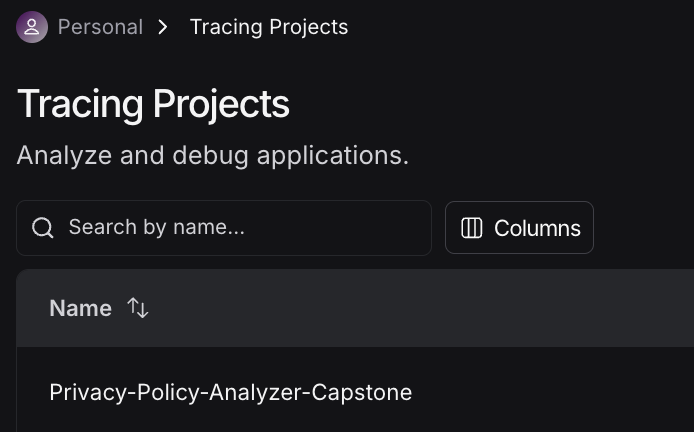

In [8]:
# Cell 4: Define data models (Hybrid: Simple Output + Loop State)
from typing import TypedDict, List, Dict, Any, Optional
from langchain_core.documents import Document
from pydantic import BaseModel, Field

class PrivacyPolicyAnalysis(BaseModel):
    """Structured analysis with direct, simple explanations."""
    # AI must identify the company first
    company_name: str = Field(..., description="The exact name of the app or company. If not found, output 'Unknown'.")
    
    
    # The "Real Talk" section - Simple English ONLY
    what_we_give: List[str] = Field(..., description="List of specific data types user gives (e.g., 'GPS Location', 'Contacts').")
    how_they_get_it: List[str] = Field(..., description="How they collect it (e.g., 'Cookies', 'Background Tracking').")
    why_they_want_it: List[str] = Field(..., description="The real reason they want it (e.g., 'Targeted Ads', 'Selling to Brokers').")
    
    # Standard compliance stuff
    retention_period: str = Field(default="Not specified", description="How long they keep data")
    risky_permissions: List[str] = Field(default_factory=list, description="Scary permissions (e.g., Microphone, Camera)")
    overall_risk_level: str = Field(..., description="Low, Medium, or High")
    
    # Explicit recommendations list
    recommendations: List[str] = Field(..., description="3-5 simple, actionable steps for the user.")

# Define the Graph State (Includes Loop fields)
class PolicyAnalyzerState(TypedDict):
    policy_text: str
    company_name: Optional[str] # Auto-filled
    chunks: List[Document]
    relevant_sections: Dict[str, str]
    extracted_info: Dict[str, Any]
    structured_analysis: Optional[PrivacyPolicyAnalysis]
    english_summary: str
    reputation_data: Dict[str, Any]
    error: Optional[str]
    # LOOP FIELDS (Required for the Feedback Logic)
    retry_count: int
    revision_feedback: Optional[str]

print("State updated: Simple Content Fields + Loop Logic enabled.")

State updated: Simple Content Fields + Loop Logic enabled.


In [10]:
# Cell 5: Document processing functions
class DocumentProcessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    
    def read_pdf(self, file_path: str) -> str:
        """Extract text from PDF file"""
        try:
            reader = PdfReader(file_path)
            text = "".join(page.extract_text() for page in reader.pages if page.extract_text())
            return text.strip()
        except Exception as e:
            return f"❌ Error reading PDF: {e}"
    
    def chunk_text(self, text: str) -> List[Document]:
        """Split text into manageable chunks for RAG"""
        if not text: return []
        try:
            documents = self.text_splitter.create_documents([text])
            return documents
        except Exception as e:
            return [Document(page_content=text)]

processor = DocumentProcessor()
print(" Document processor ready!")

 Document processor ready!
